# Import

In [1]:
# Auto-reloading (useful in Jupyter notebooks)
try:
    get_ipython()  # Check if running in Jupyter
    %load_ext autoreload
    %autoreload 2
except NameError:
    pass  # Skip autoreload if not in Jupyter

# Standard Library
import time

# Scientific Libraries
import numpy as np
import matplotlib.pyplot as plt

# JAX & Random Seed
import jax.numpy as jnp
from jax import random

# PyHGF (Hierarchical Gaussian Filter package)
import pyhgf
from pyhgf.utils import scan_sampling,sample_node_distribution
from pyhgf.model import Network
# from pyhgf import load_data  # Uncomment if using load_data

# Random seed for reproducibility
seed = int(time.time())  # Use a fixed seed (e.g., 42) for deterministic results
rng_key = random.PRNGKey(seed)

# Data loading (commented out until needed)
from pyhgf import load_data
timeserie = load_data("continuous")

# Predictive Agent
## 
In this notebook, we first create two agents: one with a binary child node (where the inputs are observed) and one with a continuous child node.
Rather than merely observing data, we want our agents to think and simulate the future by sampling from their own distributions and then inserting the samples as observations.

## Sampling the child nodes

### Continuous Agent
We create an agent with two nodes, including a child continuous node as the input.

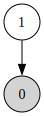

In [2]:
# Define an agent with a continuous node and display the network
agent_1 = (
    Network()  # Create a new network
    .add_nodes(precision=1e1)  # Add Node 1: Continuous node with a specified precision
    .add_nodes(value_children=[0])  # Add Node 2: Child node linked to Node 1
)
# Plot the network structure
agent_1.plot_network()

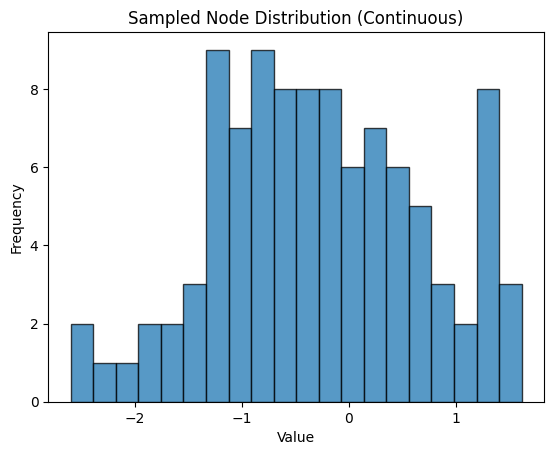

In [3]:
# Random seed for reproducibility
seed = int(time.time())  # Use a fixed seed (e.g., 42) for deterministic results
rng_key = random.PRNGKey(seed)

# Run the scan to generate multiple samples
num_samples = 100  # Number of samples to generate
samples = scan_sampling(
    agent_1.attributes,        # Network attributes
    0,                         # Node index to sample from
    rng_key,                   # Random number generator key
    agent_1.edges[0].node_type, # Node type for the specified node
    num_samples                # Number of samples to generate
)

# Plot the sampled distribution
plt.hist(samples, bins=20, alpha=0.75, edgecolor='k')  # Histogram of samples
plt.title("Sampled Node Distribution (Continuous)")    # Title of the plot
plt.xlabel("Value")                                     # X-axis label
plt.ylabel("Frequency")                                 # Y-axis label
plt.show()                                              # Display the plot

array([<Axes: title={'left': 'State Node 1'}, xlabel='Time', ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

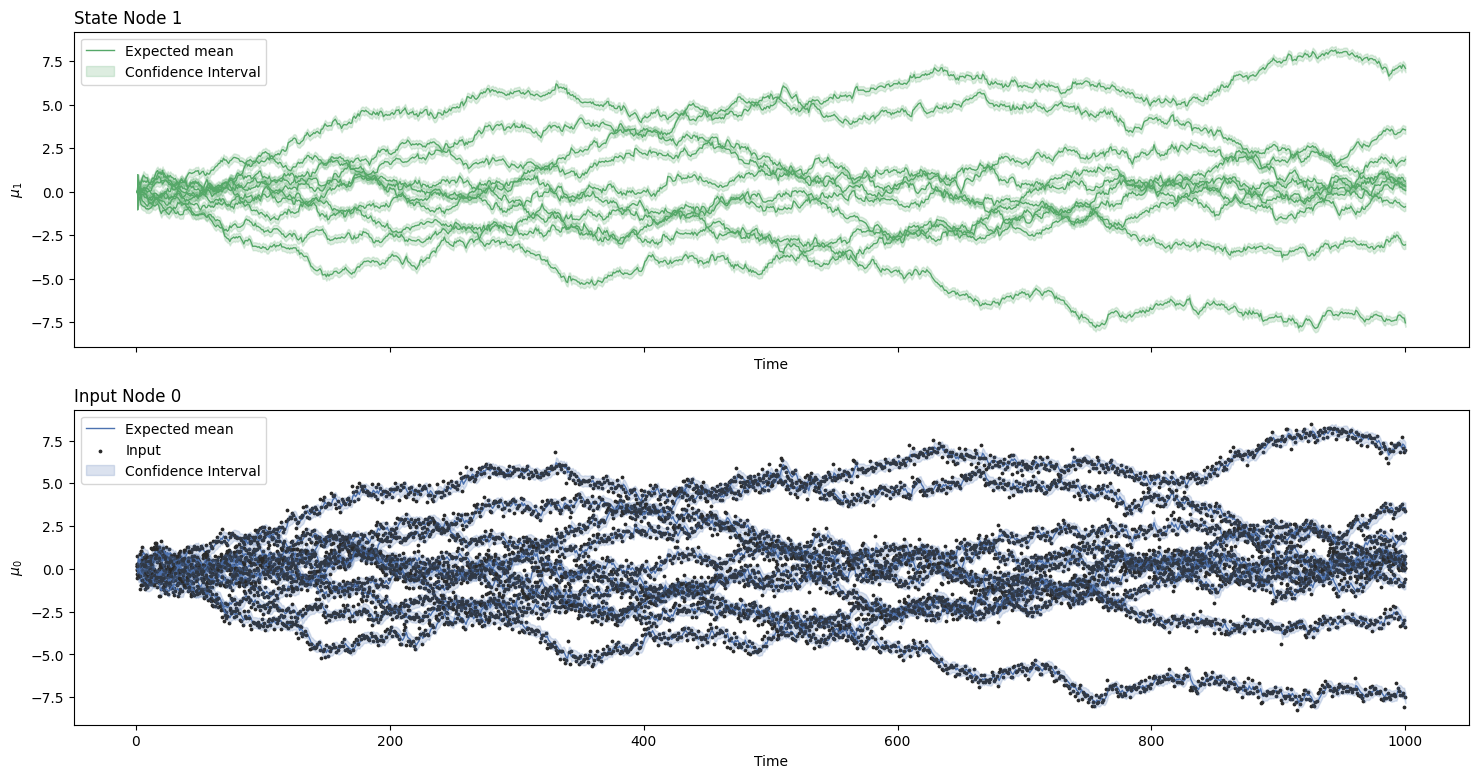

In [3]:
# Generate predictions based on the agent's internal model and inputs
rng_key, subkey = random.split(rng_key) # Split the RNG key to ensure independent randomness for different parts of the simulation
agent_1.input_data(n_trajectories=10,time_steps=np.ones(1000),rng_key=rng_key)
agent_1.plot_trajectories(show_surprise=False)

Now we want that after getting enought data, the agent project himself in the future


In [7]:
# Generate predictions based on the agent's internal model and inputs
#rng_key, subkey = random.split(rng_key) # Split the RNG key to ensure independent randomness for different parts of the simulation
#agent_1.input_data(n_trajectories=10,time_steps=np.ones(1000),rng_key=rng_key)
#agent_1.input_data(input_data=timeserie,simulate_future=True)
# probleme avec la surprise
#agent_1.plot_trajectories(show_surprise=True)

### Binary agent

In [ ]:
# Define an agent with a binary node and display the network
agent_2 = (
    Network()  # Create a new network
    .add_nodes(kind="binary-state", precision=1e2)  # Add Node 1: Binary state node with a specified precision
    .add_nodes(value_children=[0])  # Add Node 2: Child node linked to Node 1
)

# Plot the network structure
agent_2.plot_network()

In [ ]:
# Sample from the binary node
sample = sample_node_distribution(
    agent_2.attributes,        # Attributes of the network
    0,                         # Node index to sample from (Node 1)
    rng_key,                   # Random number generator key
    agent_2.edges[0].node_type # Node type for the specified node
)

# Print the sampled value along with the node's mean and precision
mean = agent_2.attributes[0]['expected_mean']
precision = agent_2.attributes[0]['expected_precision']
print(f"Sampled node with mean of {mean} and a precision of {precision}: {sample}")

samples = scan_sampling(agent_2.attributes, 0, rng_key, agent_2.edges[0].node_type, num_samples)

# Plot the results
true_count = jnp.sum(samples)
false_count = num_samples - true_count
plt.bar(["False (0)", "True (1)"], [false_count, true_count], alpha=0.75, edgecolor='k')
plt.title("Sampled Node Distribution (Discrete)")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

In [ ]:
# Ici, time_steps est un tableau de 100 valeurs (ici, 1.0 pour chaque time step)
rng_key, subkey = random.split(rng_key) # Split the RNG key to ensure independent randomness for different parts of the simulation
d = load_data("binary")
agent_2.input_data(n_trajectories=4,time_steps=np.ones(100),rng_key=rng_key)
agent_2.plot_trajectories(show_surprise=False,ci=False,show_posterior=False)

Now we want the same for the binary agent

# Auto-regressive agent
- Data
- Arrête
- Simulation
- Copy agent 
- Fonction de cout, free energy (mean belief)
- Predire churn, Intervention, Trouver donnée gap, Synthethic data
  - client (obersation continue perception du valeur du produit)

Generate synthetic binary marketing data and noisy marketing data

In [ ]:
# Generate a binary time series (0 or 1)
# 0: No marketing campaign, 1: Marketing campaign
marketing_data_binary = np.random.binomial(1, 0.1, 100)
marketing_data_continous = timeserie
# Add noise to the data
noise = np.random.normal(0, 0.05, size=marketing_data_binary.shape)  # Small standard deviation
noisy_data_binary = marketing_data_binary + noise
noise_2 = np.random.normal(0, 0.05, size=marketing_data_continous.shape)  # Small standard deviation
noisy_data_continous = marketing_data_continous + noise_2

# Plot the data
plt.figure(figsize=(12, 6))

# Scatter plot for binary data
plt.scatter(range(len(marketing_data_binary)), marketing_data_binary, color='blue', label="Original Marketing Data", alpha=0.6)

# Line plot for noisy data
plt.scatter(range(len(marketing_data_binary)),noisy_data_binary, color='orange', label="Noisy Data", alpha=0.8)

# Add title and labels
plt.title("Binary Time Series with Noise", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Add legend and grid
plt.legend(fontsize=10)
plt.grid(True, linestyle='', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

Define auto-regresive agent

In [ ]:
# Define agent and display the network
agent = (
        Network()
        .add_nodes(precision=1e2)  # Node 1: 
        .add_nodes(value_children=[0])  # Node 2
        .add_nodes(value_children=[1])  # Node 3: 
        .input_data(noisy_data_binary)  # Feed noisy marketing data into the network
    )
agent.plot_network() 

In [ ]:
# Loop through different autoconnection strengths to observe their effects
fig, axs = plt.subplots(figsize=(12, 5))

for autoconnection_strength in [0.2, 0.5, 0.8]:
    # Initialize the agent with a network
    agent = (
        Network()
        .add_nodes(precision=1e2)  # Node 1
        .add_nodes(autoconnection_strength=autoconnection_strength, value_children=[0])  # Node 2
        .add_nodes(value_children=[1])  # Node 3
        .input_data(noisy_data_binary)  # noisy marketing data into the network
    )

# Plot the expected mean trajectory of Node 2
    axs.plot(
        agent.node_trajectories[1]["expected_mean"], 
        label=f"Autoconnection strength = {autoconnection_strength}"
    )

# Add plot labels, legend, and title
axs.set_title("Effect of Marketing on Consumer Decision to Stay or Leave")
axs.set_xlabel("Time Steps")
axs.set_ylabel("Expected Decision (Leave <-> Stay)")
plt.legend()

plt.show()

In [ ]:
for autoconnection_strength in [0.2, 0.5, 0.8]:
    # Initialize the agent with a network
    agent = (
        Network()
        .add_nodes(precision=1e2)  # Node 1
        .add_nodes(autoconnection_strength=autoconnection_strength, value_children=[0])  # Node 2
        .add_nodes(value_children=[1])  # Node 3
    )
    agent.input_data(n_trajectories=2, time_steps=np.ones(100), rng_key=rng_key)
    agent.plot_trajectories(show_surprise=False, ci=False, show_posterior=False)

# Define a decision function

In [ ]:
def adjusted_sigmoid(x, alpha=1, beta=0, gamma=1):
    """
    Adjusted sigmoid function:
    - Behaves like a sigmoid at x = 0.
    - Rapidly decays towards 0 for negative x.
    - Tends to 1 for large positive x.
    """
    sigmoid = 1 / (1 + np.exp(-alpha * (x - beta)))  # Standard sigmoid
    suppression = np.exp(-gamma * np.maximum(0, -x))  # Extra decay for x < 0
    return sigmoid * suppression

In [ ]:
# Définir les paramètres de la distribution Beta
a = 2  # Paramètre de forme a (> 0)
b = 5  # Paramètre de forme b (> 0)

# Créer un tableau de valeurs u dans l'intervalle [0, 1]
u = np.linspace(0, 1, 100)

# Calculer la CDF Beta pour ces valeurs
beta_cdf_values = beta.cdf(u, a, b)

# Tracer la fonction de distribution cumulative Beta
plt.figure(figsize=(8, 5))
plt.plot(u, beta_cdf_values, label=f'CDF Beta (a={a}, b={b})')
plt.title('Fonction de Distribution Cumulative Beta')
plt.xlabel('u')
plt.ylabel('CDF Beta')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
agent.node_trajectories[1]["expected_mean"][0]

In [ ]:
x = agent.node_trajectories[0]["expected_mean"][1]  # x corresponds to time steps

# Compute probabilities using adjusted sigmoid for each gamma value
probabilities = {
    "gamma=0.5": adjusted_sigmoid(x, alpha=2, beta=0, gamma=0.5),
    "gamma=1.0": adjusted_sigmoid(x, alpha=2, beta=0, gamma=1),
    "gamma=2.0": adjusted_sigmoid(x, alpha=2, beta=0, gamma=2),
}

# Create the plot
plt.figure(figsize=(14, 8))

# Plot probabilities over time
for label, prob in probabilities.items():
    plt.plot(
        range(len(x)), prob, label=label, linewidth=2, 
        linestyle="--" if "0.5" in label else "-." if "1.0" in label else "-"
    )

# Highlight key thresholds
plt.axhline(0.5, color='red', linestyle=":", alpha=0.8, linewidth=1.5, label="Threshold (0.5)")

# Add titles and labels
plt.title("Adjusted Sigmoid Probabilities Over Time", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Probability", fontsize=14)

# Add legend and grid
plt.legend(fontsize=12, title="Parameters")
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust axis limits for clarity
plt.xlim(0, len(x) - 1)  # Time step range
plt.ylim(-0.1, 1.1)      # Probability range

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
p = probabilities["gamma=0.5"].tolist()

# Use probabilities to sample from a binomial distribution
n_trials = 1  # Single trial per time step (binary decision)
binomial_decisions = np.random.binomial(n_trials, p)

# Plot probabilities and decisions
plt.figure(figsize=(14, 6))

# Plot binomial decisions
plt.scatter(x, binomial_decisions, color="orange", label="Binomial Decisions", alpha=0.8)

# Customize plot
plt.title("Probability of Decision Function and Binomial Sampling", fontsize=16, fontweight="bold")
plt.xlabel("Input (e.g., decision factors or time steps)", fontsize=14)
plt.ylabel("Probability / Decision", fontsize=14)
plt.axhline(0.5, color="red", linestyle="--", label="Threshold (0.5)", alpha=0.7)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(12, 3))
jitter = binomial_decisions * .1 + (1-binomial_decisions) * -.1
plt.scatter(np.arange(len(noisy_data_continous)), noisy_data_continous, label="Observations", color="#4c72b0", edgecolor="k", alpha=.2)
plt.scatter(np.arange(len(binomial_decisions)), binomial_decisions + jitter, label="Responses", color="#c44e52", alpha=.2, edgecolor="k")
plt.plot(agent.node_trajectories[0]["expected_mean"][0], label="Beliefs", linestyle="--")
plt.legend()
plt.xlabel("Trials")
